In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2

## Skip until *Connection graph* (everything before is pre-processing)

### Loading data

In [2]:
# reading the csv as data frames
movies = pd.read_csv('data/movies_metadata.csv')
credits = pd.read_csv('data/credits.csv')

# set movie id as index
movies.set_index('id', inplace=True)

C:\Users\czare\Miniconda3\envs\ds\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Extracting actors (from the exploration notebook)

In [3]:
# extract all actors
cast_in_movie = []
for _, r in credits.cast.iteritems():
    for g in ast.literal_eval(r):
        cast_in_movie.append([g["name"], g["id"]])

# convert actor movie to dataframe
cast_in_movie = pd.DataFrame(cast_in_movie)
cast_in_movie.columns = ["actor", "movie_id"]

In [4]:
# group actors and count number of movies + sort
sorted_actors = cast_in_movie.groupby('actor').count().rename(columns={"movie_id": "movie_count"}).sort_values(by="movie_count", ascending=False)

# keep only actors that were in 20 or more movies
top_actors = sorted_actors[sorted_actors.movie_count >= 20]

In [5]:
top_actors

,movie_count
actor,
Bess Flowers,241
Christopher Lee,148
John Wayne,125
Samuel L. Jackson,123
Gérard Depardieu,110
...,...
Tony Roberts,20
Vic Tayback,20
Andrew Duggan,20


**Create actor nodes dataframe**

In [6]:
actor_nodes = pd.DataFrame(top_actors.index).rename(columns={'actor': 'id'})
# write to json
actor_nodes.to_json('small_data/actor_nodes.json', orient='records')

### Get list of actors per movie id

In [7]:
# extract the list of actors for a movie
def get_actors(cast):
    cast_actors = []
    for x in ast.literal_eval(cast):
        # filter for actors with more than 20 movies
        if x['name'] in top_actors.index:
            cast_actors.append(x['name'])

    return cast_actors

In [8]:
movie_cast = credits[['cast', 'id']]
# extract the list of actors for each movies 
movie_cast['actors'] = movie_cast.cast.apply(lambda x: get_actors(x))
movie_cast = movie_cast.drop('cast', axis=1)

In [9]:
movie_cast.rename(columns={'id': 'movie_id'})
# remove movies with an empty list of selected actors
movie_cast = movie_cast[movie_cast.actors.apply(lambda x: len(x) > 0)]

In [10]:
movie_cast

,id,actors
0,862,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,8844,"[Robin Williams, Kirsten Dunst, Bonnie Hunt, B..."
2,15602,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,31357,"[Angela Bassett, Loretta Devine, Dennis Haysbe..."
4,11862,"[Steve Martin, Diane Keaton, Martin Short, Geo..."
...,...,...
45467,390959,"[James Gleason, Chris Parnell]"
45468,289923,[Joshua Leonard]
45469,222848,[Ron Jeremy]
45470,30840,"[Patrick Bergin, Uma Thurman, David Morrissey,..."


### Create actor connections 

In [11]:
def get_connections(list):
    # creates list of all possible pairs in list 
    return [(a,b) for i, a in enumerate(list) for b in list[i + 1:]]

In [12]:
actor_pairs = movie_cast.actors.apply(lambda x: get_connections(x)).explode().tolist()
# cleaning
actor_pairs = [x for x in actor_pairs if str(x) != 'nan']

In [13]:
actor_pairs

[('Tom Hanks', 'Tim Allen'),
 ('Tom Hanks', 'Don Rickles'),
 ('Tom Hanks', 'Jim Varney'),
 ('Tom Hanks', 'Wallace Shawn'),
 ('Tom Hanks', 'John Ratzenberger'),
 ('Tom Hanks', 'Laurie Metcalf'),
 ('Tom Hanks', 'R. Lee Ermey'),
 ('Tim Allen', 'Don Rickles'),
 ('Tim Allen', 'Jim Varney'),
 ('Tim Allen', 'Wallace Shawn'),
 ('Tim Allen', 'John Ratzenberger'),
 ('Tim Allen', 'Laurie Metcalf'),
 ('Tim Allen', 'R. Lee Ermey'),
 ('Don Rickles', 'Jim Varney'),
 ('Don Rickles', 'Wallace Shawn'),
 ('Don Rickles', 'John Ratzenberger'),
 ('Don Rickles', 'Laurie Metcalf'),
 ('Don Rickles', 'R. Lee Ermey'),
 ('Jim Varney', 'Wallace Shawn'),
 ('Jim Varney', 'John Ratzenberger'),
 ('Jim Varney', 'Laurie Metcalf'),
 ('Jim Varney', 'R. Lee Ermey'),
 ('Wallace Shawn', 'John Ratzenberger'),
 ('Wallace Shawn', 'Laurie Metcalf'),
 ('Wallace Shawn', 'R. Lee Ermey'),
 ('John Ratzenberger', 'Laurie Metcalf'),
 ('John Ratzenberger', 'R. Lee Ermey'),
 ('Laurie Metcalf', 'R. Lee Ermey'),
 ('Robin Williams', 'Kirste

In [14]:
actor_connections_df = pd.DataFrame(actor_pairs, columns=['source', 'target'])
actor_connections_df['weigth'] = 1
actor_edges_df = actor_connections_df.groupby(['source', 'target']).weigth.count().reset_index()
actor_edges_df

,source,target,weigth
0,'Snub' Pollard,Anna Lee,1
1,'Snub' Pollard,Anne Shirley,1
2,'Snub' Pollard,Arthur Tovey,1
3,'Snub' Pollard,Bert Stevens,4
4,'Snub' Pollard,Bess Flowers,1
...,...,...,...
342242,Моррис Честнат,Taye Diggs,2
342243,Моррис Честнат,Terrence Howard,2
342244,Моррис Честнат,Tess Harper,1
342245,Моррис Честнат,Tom Lister Jr.,1


In [ ]:
# write to csv
actor_connections_df.to_csv('small_data/actor_edges.csv', index=False)

In [24]:
co_actors_df = pd.DataFrame(actor_connections_df.groupby('target')['source'].apply(list)).reset_index()
co_actors_df = co_actors_df.rename(columns={'target': 'actor', 'source': 'co_actors'})
co_actors_df.to_csv('small_data/co_actors.csv', index=False)

### Connection graph

**Load the data for connections**

In [52]:
actor_pairs_df = pd.read_csv('small_data/actor_edges.csv')
connections_df = pd.DataFrame(actor_connections_df.groupby('co_actor')['actor'].apply(list)).reset_index()
connections_df = connections_df.rename(columns={'co_actor': 'actor', 'actor': 'co_actors'})

In [53]:
connections_df

,actor,co_actors
0,'Snub' Pollard,"[Gene Kelly, Debbie Reynolds, Cyd Charisse, Do..."
1,50 Cent,"[Samuel L. Jackson, Jessica Biel, Robert De Ni..."
2,Aamir Khan,"[Hrithik Roshan, Boman Irani, Naseeruddin Shah..."
3,Aaron Eckhart,"[Elisabeth Shue, Al Pacino, Cameron Diaz, Denn..."
4,Aaron Paul,"[James Franco, Jeff Bridges, Kevin Spacey, Mar..."
...,...,...
3767,Zoe Kazan,"[Anthony Hopkins, Ryan Gosling, David Strathai..."
3768,Zoe Saldana,"[Kirsten Dunst, Ben Foster, Colin Hanks, Johnn..."
3769,Zooey Deschanel,"[Hope Davis, Jason Lee, Alfre Woodard, Kate Hu..."
3770,Zoë Kravitz,"[Catherine Zeta-Jones, Aaron Eckhart, Abigail ..."


In [58]:
def get_connections(actor):

    G = nx.Graph()
    nodes_list = []
    edges_list = []
    nodes_list = connections_df[connections_df.actor == actor].co_actors.tolist()[0]
    G.add_node(actor)
    print(nodes_list)
    G.add_nodes_from(nodes_list)
    edges_list = [(actor, x) for x in nodes_list]
    G.add_edges_from(edges_list)

    return G

['Lily Tomlin', 'Tony Curtis', 'Susan Sarandon', 'Whoopi Goldberg', 'Antonio Fargas', 'Shirley MacLaine', 'Tom Everett Scott', 'Johnathon Schaech', 'Sally Field', 'James Rebhorn', 'Leonardo DiCaprio', 'Elijah Wood', 'Adam Baldwin', 'John Heard', 'Ben Johnson', 'Dan Aykroyd', 'Owen Wilson', 'Paul Newman', 'Bonnie Hunt', 'Tony Shalhoub', 'Cheech Marin', 'George Carlin', 'Paul Dooley', 'Jenifer Lewis', 'Michael Keaton', 'John Ratzenberger', 'Jeremy Piven', 'Jay Leno', 'Martin Sheen', 'Mel Gibson', 'Hank Azaria', 'Harry Shearer', 'Kelsey Grammer', 'Joe Mantegna', 'John Malkovich', 'Colin Hanks', 'Emily Blunt', 'Steve Zahn', 'Stacy Keach', 'Keith David', 'Keith David', 'Tom Hanks', 'Josh Lucas', 'Bobby Cannavale', 'Samuel L. Jackson', 'Eli Wallach', 'Adam Arkin', 'Bobby Cannavale', 'Eric Idle', 'David Bowie', 'Billy Connolly', 'Carrie Fisher', 'Kevin Nealon', "Catherine O'Hara", 'Robin Williams', 'Steve Martin', 'Bill Murray', 'Emma Thompson', 'Tim Allen', 'Blake Clark', 'Carlos Alazraqui',

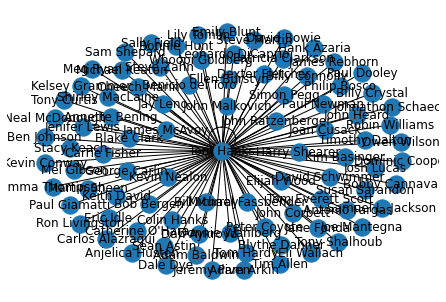

In [59]:
G = get_connections('Tom Hanks')

print(nx.info(G))
nx.draw_spring(G, with_labels=True)

In [60]:
G.nodes()

NodeView(('Tom Hanks', 'Lily Tomlin', 'Tony Curtis', 'Susan Sarandon', 'Whoopi Goldberg', 'Antonio Fargas', 'Shirley MacLaine', 'Tom Everett Scott', 'Johnathon Schaech', 'Sally Field', 'James Rebhorn', 'Leonardo DiCaprio', 'Elijah Wood', 'Adam Baldwin', 'John Heard', 'Ben Johnson', 'Dan Aykroyd', 'Owen Wilson', 'Paul Newman', 'Bonnie Hunt', 'Tony Shalhoub', 'Cheech Marin', 'George Carlin', 'Paul Dooley', 'Jenifer Lewis', 'Michael Keaton', 'John Ratzenberger', 'Jeremy Piven', 'Jay Leno', 'Martin Sheen', 'Mel Gibson', 'Hank Azaria', 'Harry Shearer', 'Kelsey Grammer', 'Joe Mantegna', 'John Malkovich', 'Colin Hanks', 'Emily Blunt', 'Steve Zahn', 'Stacy Keach', 'Keith David', 'Josh Lucas', 'Bobby Cannavale', 'Samuel L. Jackson', 'Eli Wallach', 'Adam Arkin', 'Eric Idle', 'David Bowie', 'Billy Connolly', 'Carrie Fisher', 'Kevin Nealon', "Catherine O'Hara", 'Robin Williams', 'Steve Martin', 'Bill Murray', 'Emma Thompson', 'Tim Allen', 'Blake Clark', 'Carlos Alazraqui', 'Bob Bergen', 'Joan Cusa

### Creating network examples for 10 actors with most connections

In [27]:
actors_sample = actor_nodes.sample(30)
actors_sample

,id
936,Alan Tudyk
493,Toni Collette
3730,Peter Maloney
244,Ed Lauter
1172,Kelsey Grammer
415,Seth Green
1402,Stefania Sandrelli
3354,Ali Larter
1990,Jerry O'Connell
464,Stephen McHattie


In [49]:
from_source = actor_connections_df[actor_connections_df.source.apply(lambda x: x in actors_sample.id.tolist())]
sample_connections = from_source[from_source.target.apply(lambda x: x in actors_sample.id.tolist())]

In [50]:
sample_connections

,source,target,weigth
8727,Stephen McHattie,George Lucas,1
36445,Peter Maloney,Seth Green,1
37133,Ian Holm,Luke Perry,1
49804,Ed Lauter,William Prince,1
54200,Jon Voight,Seth Green,1
56646,Jon Voight,Ali Larter,1
208497,Stephen McHattie,Ethan Suplee,1
215632,Toni Collette,Nick Searcy,1
234358,Kelsey Grammer,Jon Voight,1
243682,Ali Larter,Jerry O'Connell,1


In [51]:
in_source = actors_sample[actors_sample.id.apply(lambda x: x in sample_connections.source.tolist())]
in_target = actors_sample[actors_sample.id.apply(lambda x: x in sample_connections.target.tolist())]
not_in_source = in_target[in_target.id.apply(lambda x: x not in in_source.id.tolist())]

In [52]:
actors_sample_clean = pd.concat([in_source, not_in_source], axis=0)

In [55]:
# write to json
actors_sample_clean.to_json('small_data/sample_actor_nodes.json', orient='records')
sample_connections.to_json('small_data/sample_actor_edges.json', orient='records')